In [3]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from utils.plot_utils import plot_confusion_matrix

# Numerical
import scipy as sp
import numpy as np
import pandas as pd

# Machine Learning
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

In [4]:
# loading bag of ingredients represetation
boi = pd.read_csv('dataset/bag_of_ingre_w_cuisine.csv', index_col=0)
cuisines_df = pd.read_csv('dataset/Cuisines.csv', names=['cuisine'])

# make boi cuisine labels match actual cuisine labels
boi['cuisine'] = boi['cuisine'].transform(lambda x: x+1, axis=0)

In [5]:
boi.head()

,acorn_squash,adobo,african_birdseye_chile_pepper,ale,aleppo_pepper,alfalfa_sprouts,alfredo_sauce,allspice,almond,almond_butter,...,yeast,yellow_curry_paste,yellow_food_coloring,yellow_split_pea,yellow_squash,yogurt,zaatar,zest,zucchini,cuisine
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
cuisines_df

,cuisine
1,Chinese
2,English
3,French
4,German
5,Greek
6,Indian
7,Italian
8,Japanese
9,Mexican
10,Moroccan


In [7]:
# Split into data and labels

X = boi.drop(["cuisine"], axis=1)
y = boi["cuisine"]

In [8]:
# Split into train/valid/test

X_train_cv, X_test, y_train_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_ho, X_valid, y_train_ho, y_valid = train_test_split(X_train_cv, y_train_cv, test_size=0.20, random_state=42)

In [9]:
# Dummy baseline

np.set_printoptions(precision=2)
strategies = ["most_frequent", "uniform"]

cm = []
for st in strategies:
    
    print("\n")
    print(f"Dummy Classifier with strategy: {st}")
    print("\n")
    
    pipe = Pipeline([(st, DummyClassifier(strategy=st))])
    pipe.fit(X_train_ho, y_train_ho)
    train_acc = pipe.score(X_train_ho, y_train_ho)
    test_acc = pipe.score(X_test, y_test)
    preds = pipe.predict(X_test)

    # Print results
    print("Dummy classification accuracy on training set:") 
    print("Using the accuracy_score() function: {:.3f}".format(train_acc))
    print("Dummy classification accuracy on test set:") 
    print("Using the accuracy_score() function: {:.3f}".format(test_acc))
    
    cm.append(confusion_matrix(y_test, preds, normalize="true"))   




Dummy Classifier with strategy: most_frequent


Dummy classification accuracy on training set:
Using the accuracy_score() function: 0.091
Dummy classification accuracy on test set:
Using the accuracy_score() function: 0.078


Dummy Classifier with strategy: uniform


Dummy classification accuracy on training set:
Using the accuracy_score() function: 0.079
Dummy classification accuracy on test set:
Using the accuracy_score() function: 0.080


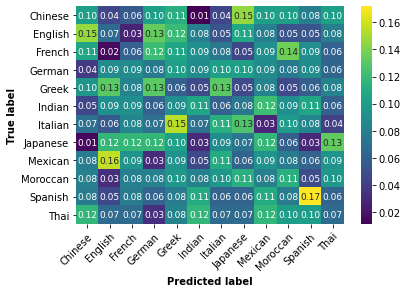

In [10]:
plot_confusion_matrix(cm[1], class_labels=cuisines_df.to_numpy(dtype="<U28").squeeze())

In [20]:
# Comparison of classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

random_state = 42

names = ["Dummy, most frequent", "Gaussian Naive Bayes", "Logistic Regression",
         "Nearest Neighb (10)", "Nearest Neighb (5)",
         "Linear SVC", "RBF SVC",
         "Random Forest", "MLP", "MLP stronger reg", "XGB"]
classifiers = [
    DummyClassifier(strategy='most_frequent'),
    GaussianNB(),
    LogisticRegression(max_iter=1000),
    KNeighborsClassifier(n_neighbors=10),
    KNeighborsClassifier(n_neighbors=5), 
    SVC(kernel="linear", probability=True, random_state=random_state),
    SVC(kernel='rbf', probability=True, random_state=random_state),
    RandomForestClassifier(max_depth=10, n_estimators=50,random_state=random_state),
    MLPClassifier(random_state=random_state, max_iter=800),  # default regularisation
    MLPClassifier(random_state=random_state, max_iter=800, alpha=1), # more regularisation
    XGBClassifier()
    ]

# Training 
ca_train_score = {}  # Classification accuracy
ce_train_score = {}  # Cross-entropy

# Validation
ca_val_score = {} 
ce_val_score = {}

# Predictions
preds = {} 

for name, clf in zip(names, classifiers):
    clf.fit(X_train_ho, y_train_ho)
    
    ca_train_score[name] = clf.score(X_train_ho, y_train_ho)
    ce_train_score[name] = log_loss(y_train_ho, clf.predict_proba(X_train_ho))
    
    ca_val_score[name] = clf.score(X_valid, y_valid)
    ce_val_score[name] = log_loss(y_valid, clf.predict_proba(X_valid))
    
    preds[name] = clf.predict(X_valid)

/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [21]:
 # Your code goes here (evaluation)

print('Classification performance on validation set: \n')
print("{0:<20s}   {1:-^25s}   {2:-^21s}".format('','Validation', 'Training'))
print("{0:<20s}{1:>13s}{2:>13s}{3:>13s}{4:>13s}".format(
    'Method', 'Accuracy\u2191', 'Log-loss\u2193',
    'Accuracy\u2191', 'Log-loss\u2193'))
print("-"*(20+4*13))
for clf in names:
    print ("{method:<20s}{val_accuracy:>13.3f}{val_logloss:>13.3f}{train_accuracy:>13.3f}{train_logloss:>13.3f}".format(
        method=clf, val_accuracy=ca_val_score[clf], val_logloss=ce_val_score[clf],
        train_accuracy=ca_train_score[clf], train_logloss=ce_train_score[clf]))

Classification performance on validation set: 

                       -------Validation--------   ------Training-------
Method                  Accuracy↑    Log-loss↓    Accuracy↑    Log-loss↓
------------------------------------------------------------------------
Dummy, most frequent        0.060       32.450        0.091       31.404
Gaussian Naive Bayes        0.550       15.184        0.703        9.738
Logistic Regression         0.782        0.752        0.921        0.349
Nearest Neighb (10)         0.658        2.814        0.727        0.794
Nearest Neighb (5)          0.621        4.629        0.764        0.597
Linear SVC                  0.736        0.836        0.961        0.343
RBF SVC                     0.776        0.742        0.934        0.244
Random Forest               0.698        1.484        0.803        1.335
MLP                         0.739        1.840        1.000        0.005
MLP stronger reg            0.783        0.737        0.896        0.450
XGB

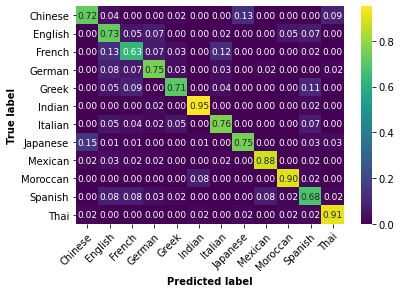

In [15]:
names = ["Dummy, most frequent", "Gaussian Naive Bayes", "Logistic Regression",
         "Nearest Neighb (10)", "Nearest Neighb (5)",
         "Linear SVC", "RBF SVC",
         "Random Forest", "MLP", "MLP stronger reg", 'XGB']

cm = confusion_matrix(y_valid, preds["RBF SVC"], normalize="true")
plot_confusion_matrix(cm, class_labels=cuisines_df.to_numpy(dtype="<U28").squeeze())

### Hyperparameter Tuning

In [18]:
# to support arbitrarily many hidden layers
class MyRandInt():
    """Wrapper class to return multivariate rand ints"""
    
    def __init__(self, low, high, dim):
        self.low = low
        self.high = high
        self.dim = dim
    
    def rvs(self, random_state=None):
        # increase proba to sample most complex config (hack, don't take too seriously)
        if stats.bernoulli.rvs(0.1):
            return np.full(self.dim, self.high, dtype=int)
        else:
            return stats.randint.rvs(self.low, self.high, size=(1, self.dim), random_state=random_state)[0]

n_layers = 2

if n_layers>1:
    print("Consider MLP with", n_layers, "hidden layers")
    mydistr = MyRandInt(10,100, n_layers)
else:
    # case of one hidden layer
    print("Consider MLP with one hidden layer")
    mydistr = stats.randint(10, 100)  

Consider MLP with 2 hidden layers


In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from scipy.stats import loguniform

def my_randomized_search_cv(X_train, y_train, search_space, n_iter=10,
                            cv=None, cvs_params=None, refit=True, verbose=False):
    """Maximises a cross-validation score by random search
    
    Parameters
    ------------
    Xtrain : nd array, (n_samples, n_features)
        Features used for training
    
    ytrain: nd array, (n_samples,)
        Labels used for training
        
    search_space: list
        Each element of the list must be a tuple (id, classifier_object, param_distributions)
        - id is a string
        - classifier_object is an instance of a classifier
        - param_distributions is a dictionary defining the search space of the hyperparameters,
          the entries can either be lists, or objects implementing a rvs() method returning a
          random sample.
          
    n_iter: int
        Number of trials in the random search
        
    cv: int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy, used with
        sklearn.model_selection.cross_val_score
        
    cvs_params: options passed to sklearn.model_selection.cross_val_score
        
    refit: bool
        Refit best estimator on the whole dataset
    
    verbose: bool
        Prints debug info
    
    Returns
    --------
    cv_scores: list
        list with cv scores
    
    configs: list
        list with sampled configurations
        
    best_estimator: 
        refitted estimator (if refit=True, else None is returned)
    
    """
    
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True)                              

    if verbose:
        print("cv strategy", cv)
        
    if cvs_params is None:
         cvs_params = dict(n_jobs=-1, scoring="accuracy")
            
    # your code goes here
    
    # Number of classifiers
    L = len(search_space)
    
    # Random search
    cv_scores = []
    configs = []
    
    for trial in range(0, n_iter):
        
        if verbose:
            print("--"*20)
            print("Trial", trial)
            print("--"*20)
            
        # pick classifier
        index = np.random.choice(L)
        
        # sample a parameter configuration for the selected classifier   
        my_id = search_space[index][0]
        clf = search_space[index][1]
        param_distr = search_space[index][2]
        
        param_dict = {}
        for k, v in param_distr.items():
            if isinstance(v, list):
                param_dict[k] = np.random.choice(v)
            else:
                param_dict[k] = v.rvs()

        # construct pipeline
        pipe = Pipeline([(my_id, clf)])
        pipe.set_params(**param_dict)
        
        if verbose:
            print("Parameters", param_dict)
            print("Pipeline:", pipe)
            
        # compute cv score
        scores_tmp = cross_val_score(pipe, X_train, y_train, cv=cv, **cvs_params)
        
        if verbose:
            print("cv score:", scores_tmp)
                
        # store
        cv_scores.append(np.mean(scores_tmp))
        configs.append(pipe)
    
    if refit:
        print("--"*20)
        print("Selecting and refitting best classifier")
        print("--"*20)
        best_index = np.argmax(cv_scores)
        best_score = cv_scores[best_index]
        best_estimator = configs[best_index]
        best_estimator.fit(X_train, y_train)
        
        if verbose:
            print("best score:", best_score)
            print("best pipe:", best_estimator)
    else:
        best_estimator = None
        
    return cv_scores, configs, best_estimator

In [20]:
# define classifiers and hyperparameters to search over
svc = SVC()
params_svc = {'svc__kernel' : ['linear', 'rbf'],
              'svc__C': loguniform(10**(-5),10**2)}

search_space = [('svc', svc, params_svc)]

# do the search
svc_cv_scores, _, svc_best_estimator = my_randomized_search_cv(X_train_cv, y_train_cv, search_space, n_iter=200, verbose=True)

cv strategy StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
----------------------------------------
Trial 0
----------------------------------------
Parameters {'svc__kernel': 'linear', 'svc__C': 41.522133626059905}
Pipeline: Pipeline(steps=[('svc', SVC(C=41.522133626059905, kernel='linear'))])
cv score: [0.7  0.71 0.71 0.69 0.71]
----------------------------------------
Trial 1
----------------------------------------
Parameters {'svc__kernel': 'linear', 'svc__C': 0.04577918460789367}
Pipeline: Pipeline(steps=[('svc', SVC(C=0.04577918460789367, kernel='linear'))])
cv score: [0.74 0.75 0.73 0.73 0.72]
----------------------------------------
Trial 2
----------------------------------------
Parameters {'svc__kernel': 'rbf', 'svc__C': 0.010042305374843045}
Pipeline: Pipeline(steps=[('svc', SVC(C=0.010042305374843045))])
cv score: [0.09 0.09 0.09 0.09 0.09]
----------------------------------------
Trial 3
----------------------------------------
Parameters {'svc__kernel': 'r

best score: 0.7680056469850067
best pipe: Pipeline(steps=[('svc', SVC(C=0.0037680589728301944))])


In [ ]:
mlp = MLPClassifier(max_iter=1600)  # 800 may sometimes not be enough and you will see a warning.
params_mlp = {'mlp__alpha' : loguniform(10**(-5),10**2),
              'mlp__hidden_layer_sizes': stats.randint(10, 100)}

In [ ]:
search_space = [('mlp', mlp, params_mlp)]
# do the search
mlp_cv_scores,_, mlp_best_estimator = my_randomized_search_cv(X_train_cv, y_train_cv, search_space, n_iter=200, verbose=True)

In [ ]:
lr = LogisticRegression(max_iter=1000)
params_lr = {'penalty': ['l2', 'l1', 'elasticnet', 'none']}

In [ ]:
search_space = [('lr', lr, params_lr)]
# do the search
lr_cv_scores,_, lr_best_estimator = my_randomized_search_cv(X_train_cv, y_train_cv, search_space, n_iter=200, verbose=True)

In [ ]:
rf = RandomForestClassifier(max_depth=10, n_estimators=50, random_state=random_state)
params_rf = {'max_depth': loguniform(10**1,10**3),
            'n_estimators': loguniform(10**1,10**4)}

In [ ]:
search_space = [('rf', rf, params_rf)]
# do the search
rf_cv_scores,_, rf_best_estimator = my_randomized_search_cv(X_train_cv, y_train_cv, search_space, n_iter=200, verbose=True)